# Introducing Jupyter
<img src="https://cdn-images-1.medium.com/max/1920/1*wOHyKy6fl3ltcBMNpCvC6Q.png" width='400'>
<p>Jupyter is an open source project for interactive data science and scientific computing that comes with the Anaconda distribution of Python. Notebooks make collaboration easier by allowing you to share code, output, and notes with colleagues all in one place. Jupyter is built around the idea of cells. Code cells contain Python code that can be run by pressing "Shift Enter". If your code cell has any kind of output (calculation, graph, table, or etc.) that output will be shown directly beneath the code cell that produced it. This allows you to break up your programs into chunks that can be run independently to allow for rapid modification of programs without having to rerun the whole thing. Markdown cells further add to the experience by allowing you to write about what is happening in your programs using fairly simple formatting syntax.</p>

## Today's Demonstration
<p>I'm going to demonstrate a little bit of what Jupyter can do for you in this notebook. We're going to use the BLS API get some unemployment and price data and then graph it. We use two Python packages "requests" and "json" to use the API and get the results into a format that we can work with, but we'll be mainly relying on two powerful Python packages (Pandas and Matplotlib) for the data analysis and graphing.</p>

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import datetime
%matplotlib inline

# Unemployment and CPI Data
<p>Our first examples are going to use the unemployment data and CPI data pulled from the public BLS API. I'm using Version 1.0 of the API which does not require any registration, so anyone who has access to this notebook should be able to run it.</p>

## Getting the Data
<p>Below I define the API call I'm going to be making by specifying which series I'm interested in and my start and end years. The Seriesid, startyear, and endyear are three arguments that the BLS API expects when you make an API call for data. You have to know which series you want to pull and the timeframe you're interested in. The BLS API returns the results as a JSON string which I'm then able to turn into a Python dictionary. One of the benefits of using Python is that it comes with native data structures that are extremely useful. A dictionary is one of these data structures. Just like an ordinary dictionary a Python dictionary is defined by keys and values. Since the dictionary I've stored in json_data actually contains the values for both series I requested, I split it into two different dictionaries containing the CPI data and the unemployment rate data I requested. Looking at an example of one row of the CPI data we pulled, you may notice that the number '237.336' has quotes around it. That will prove important a little bit later.</p>

In [2]:
headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": ['CUUR0000SA0','LNS14000000'],
                   "startyear":"2006", "endyear":"2016"})

p = requests.post('https://api.bls.gov/publicAPI/v1/timeseries/data/', 
                  data=data, headers=headers)

json_data = json.loads(p.text)

cpi = json_data['Results']['series'][1]['data']
unemp = json_data['Results']['series'][0]['data']
print(cpi[1])

{'year': '2015', 'period': 'M11', 'periodName': 'November', 'value': '5.0', 'footnotes': [{}]}


## Data Prepping
<p>As I was looking at the data I got from the API call, I realized that it was giving me date information in three columns: 'period', 'periodName', and 'year'. Since my goal is to graph the data by month, I needed to transform this into a single 'Date' column formatted as a datetime variable. To do this I define a function <code>date_maker()</code> that takes a Pandas DataFrame as an argument and first creates a variable that is the concatenation of "1 ", 'periodName', ", ", and 'year' so that I'm left with something like 1 December, 2015. Then I reformat that column as a datetime variable using the <code>'%d %B, %Y'</code> datetime formatter. You'll notice that within this step is a cryptic <code>lambda x:</code>. It may look confusing, but what's happening is actually quite simple. The <code>datetime</code> package already provides a means of converting things into dates, but it doesn't work on columns of data. I circumvent this by using Pandas <code>apply</code> method which allows functions to operate row-by-row. From there, I could have defined a new function that just passes values to <code>datetime.strptime()</code> for conversion. Instead of going to that trouble I use Python's native way of creating an "anonymous" <code>lambda</code> function. These kinds of functions are useful if you need to write a function within another function or if you plan on using a function only once and don't really care if Python holds it in memory after you're done with it.</p> 

In [3]:
def date_maker(df):
    df['Date'] = "1 " + df['periodName'] + ", " + df['year']
    df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%d %B, %Y'))

<p>Now that we have a function for making nice dates out of what we've gotten from the API, we need to read it into a Pandas data frame. Pandas comes with a host of methods that make reading in data very easy. Since the data is stored as a Python dictionary, we'll use the <code>from_dict()</code> method. Remember earlier when we noticed the quotes around the CPI? The actual data coming in is formated as an <code>object</code> and not as a number. I have no idea why the BLS API passed the numbers that way, but thankfully this gives us an opportunity to explore type converstion in Pandas. In short, it was incredibly easy to fix this problem by reformatting the variable as a <code>float</code>. Once we have everything saved in a data frame, we need to use our <code>date_maker</code> function and then I'll sort the data frame so that it's in chronological order. Below you can see the basic structure of our DataFrame is by looking at the first 5 observations.</p>

In [4]:
df1 = pd.DataFrame.from_dict(unemp)
df1['unemp'] = df1['value'].astype(float)
date_maker(df1)
df1.set_index('Date', inplace=True)
df1.sort_index(inplace=True)
df1[['period', 'periodName', 'unemp', 'year']].head()

,period,periodName,unemp,year
Date,,,,
2006-01-01,M01,January,198.3,2006
2006-02-01,M02,February,198.7,2006
2006-03-01,M03,March,199.8,2006
2006-04-01,M04,April,201.5,2006
2006-05-01,M05,May,202.5,2006


## Graphing Example 1: Monthly Unemployment Rate
<p>Now that we have the data stored in a Pandas DataFrame it's very easy to graph the results with Matplotlib. We'll also see that making changes in Jupyter is extremly easy - just modify the code cell and rerun it.</p>
1. Figure too small? - change it!
2. Don't like the color? - change it!
3. Regret a change? - change it again!

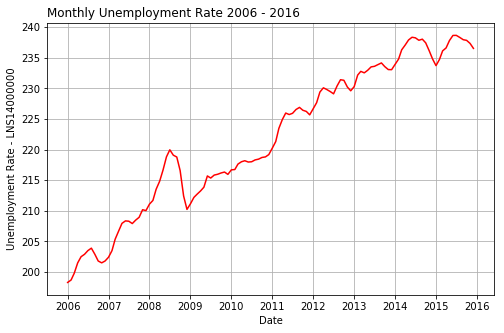

In [5]:
plt.figure(figsize=(8,5))
plt.title('Monthly Unemployment Rate 2006 - 2016', loc='left')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate - LNS14000000')
plt.plot(df1.index, df1['unemp'], color='red')
plt.grid()
plt.show()

## Graphing Example 2: Monthly Inflation Rates
<p>Next we do something similar with the monthly CPI data we pulled earlier. Above we didn't have to manipulate the data all that much because the unemployment rate was already in a format we liked - monthly rates. The CPI however was pulled in as monthly index values. We're probably instead interested in inflation rates either monthly or annually. We'll see that getting price changes from the index value is pretty easy with built-in Pandas functions like <code>pct_change(periods)</code>. In addition we'll explore the <code>group_by</code> function and its aggregation tools like <code>mean()</code>. These will allow us to get annual inflation rates from monthly CPI values.</p>

In [6]:
df2 = pd.DataFrame.from_dict(cpi)
df2['value'] = df2['value'].astype(float)
date_maker(df2)
df2.set_index('Date', inplace=True)
df2.sort_index(inplace=True)
df2[['period', 'periodName', 'value', 'year']].head()

,period,periodName,value,year
Date,,,,
2006-01-01,M01,January,4.7,2006
2006-02-01,M02,February,4.8,2006
2006-03-01,M03,March,4.7,2006
2006-04-01,M04,April,4.7,2006
2006-05-01,M05,May,4.6,2006


<p>From the CPI level value we'll calculate monthly percent changes. Pandas comes with a function <code>pct_change(periods)</code> that allows us to calculate the percent change in a variable and provides us the option of specifying periods. Setting <code>period=1</code> would give us the month-to-month percent change, setting <code>period=12</code> gives us the percent change from a year ago. We also multiply the result by 100 so it's not in decimal values. But, we are often also interested in the <i>annual</i> inflation rate. To get that we'll first calculate the mean CPI for each year using Pandas' <code>group_by(variable)</code> along with the <code>mean()</code> aggregation function. Then we'll just calculate the annual percent change in the CPI and multiply it by 100 again. Pandas comes with a lot of different aggregation functions you can use and allows you to define your own.

In [7]:
df2['monthly'] = df2['value'].pct_change(periods=12) * 100
annual = df2.groupby('year').mean()['value'].pct_change(periods=1) * 100

Now that we have all the data in a form we're happy with, it's a simple matter to graph it again. This time since we actually have two different data series we want to plot, you'll notice that we call the <code>plot(x,y)</code> function twice. I also added a legend with <code>plt.legend()</code>. 

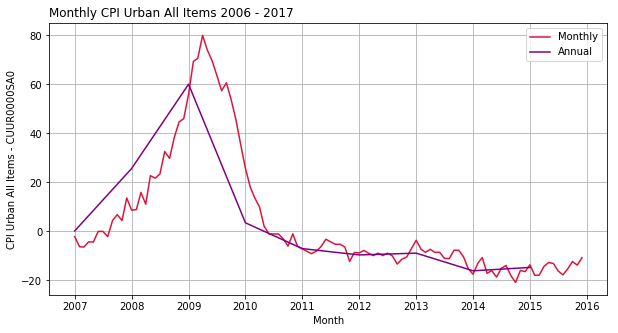

In [8]:
plt.figure(figsize=(10,5))
plt.plot(df2.index, df2['monthly'], color='crimson', label='Monthly')
plt.plot(annual.index, annual.values, color='purple', label='Annual')
plt.title('Monthly CPI Urban All Items 2006 - 2017', 
          loc='left')
plt.ylabel('CPI Urban All Items - CUUR0000SA0')
plt.xlabel('Month')
plt.grid()
plt.legend()
plt.show()

# Consumer Expenditures
<p>I work on the Consumer Expenditures Survey so naturally, I couldn't to do a Jupyter demonstration without showing off our data a little. I took some of the 2016 CE Public Use Microdata (PUMD) and saved to a github repository so you should be able to read it directly from there. For this example, we're going to read in the data as a csv directly from my github,  combine the four quarterly files together to get an annual file, find total expenditures for the main expenditure categories by the highest educational attainment of any household member, calculate the budget shares, and then graph them.</p>

## Getting the Data
<p>Pandas has functions for reading in tabular files of many different kinds. It can read in CSV files, TXT files, STATA files, SAS files, and others. I'm going to show you how Pandas handles reading CSVs since it has a pretty sophisticated function for that. The function <code>read_csv()</code> has arguments for:</p>

1. <code>usecols</code>: the columns you actually want to read in from the csv
2. <code>dtype</code>: how you want Pandas to treat specific variables (int/float/string)
3. <code>na_values</code>: what values Pandas should treat as missing (B/NaN/NA)
4. <code>low_memory</code>: check for columns of mixed data types when reading


<p>Once we've read in the CSV, we can pass each of the data frames to pandas <code>cat</code> function. This will concatenate (append) each of the data frames into a single data frame.</p>

In [9]:
keep_cols = ['FOODPQ', 'HOUSPQ', 'APPARPQ', 
             'TRANSPQ', 'HEALTHPQ', 'ENTERTPQ',
             'CASHCOPQ', 'PERINSPQ', 'FINLWT21', 
             'HIGH_EDU']

git = r'https://raw.githubusercontent.com/clayknappen/Jupyter-Demonstration/master//'

fmly161 = pd.read_csv(git + r'fmli161x.csv', 
                      usecols=keep_cols, low_memory=False)
fmly162 = pd.read_csv(git + r'fmli162.csv',
                      usecols=keep_cols, low_memory=False)
fmly163 = pd.read_csv(git + r'fmli163.csv',
                      usecols=keep_cols, low_memory=False)
fmly164 = pd.read_csv(git + r'fmli164.csv',
                      usecols=keep_cols, low_memory=False)
fmly171 = pd.read_csv(git + r'fmli171.csv',
                      usecols=keep_cols, low_memory=False)

fmly = pd.concat([fmly161, fmly162, fmly163, fmly164, fmly171])
del fmly161, fmly162, fmly163, fmly164, fmly171
fmly[['FINLWT21', 'FOODPQ', 'HOUSPQ', 'HIGH_EDU']].head()

,FINLWT21,FOODPQ,HOUSPQ,HIGH_EDU
0,13238.010,1480.0,4440.0,15
1,16071.313,1820.0,2693.0,15
2,5601.575,1755.0,4578.0,14
3,21881.269,949.0,2295.0,13
4,23491.257,1300.0,4976.0,12


<p>Now that we have the data all in a single file, let's do some manipulation to summarize it. We're going to look at budget shares for different expenditure categories by the highest level of education attained by anyone in the household. We don't have all the expenditure categories in our data, but the ones we do have add up to almost 100% so it's close enough for our purposes. First we need to group the data frame by the <code>HIGH_EDU</code> variable. Then we'll use the <code>sum()</code> function on that grouping to get our summary table as a result. Next, we'll calculate total expenditures based on the eight categories we have. We're hoping to say something about the population though so we need to multiply the total by the CE weight variable <code>FINLWT21</code>. Then, we'll calculate the weighted budget shares by going through each of the eight expenditure categories, multiplying the sum by the sum of the weights and then dividing that result by the weighted total. We multiply by 100 to get nicer looking numbers. Finally, we rename the index so that it has text descriptions of the different education categories.

To summarize: we took the following steps - </p>
1. Group data by <code>HIGH_EDU</code>
2. Calculate weighted total expenditures
3. Get weighted budget shares for each expenditure category
4. Rename the index to have better labels

In [10]:
tab = fmly.groupby('HIGH_EDU').sum()

exp_vars = ['HOUSPQ', 'FOODPQ', 'TRANSPQ',
            'PERINSPQ', 'ENTERTPQ', 'HEALTHPQ', 
            'CASHCOPQ', 'APPARPQ']

tab['TOTAL'] = tab['FINLWT21'] * tab[exp_vars].sum(axis=1)

for var in exp_vars:
    tab[var] = 100 * ((tab['FINLWT21'] * tab[var]) / tab['TOTAL'])

tab.index = ['Never Attended', '1st-8th Grade', '9th-12th Grade', 
             'HS Graduate', 'Some College', 'AA Degree', 'Bachelors Degree',
             'Graduate Degree']
tab[exp_vars]

,HOUSPQ,FOODPQ,TRANSPQ,PERINSPQ,ENTERTPQ,HEALTHPQ,CASHCOPQ,APPARPQ
Never Attended,51.200234,21.284746,6.766784,5.794034,2.794502,8.383436,1.677994,2.098270
1st-8th Grade,40.662582,22.973277,12.117848,7.323473,3.733885,9.156901,2.167654,1.864381
9th-12th Grade,40.105243,21.379710,14.664136,7.028094,4.369791,8.452174,2.016728,1.984123
HS Graduate,36.357071,18.164056,17.891686,9.090040,4.435079,9.719230,2.548017,1.794820
Some College,35.105284,16.912918,18.232643,10.496161,5.022415,8.477315,3.753458,1.999805
AA Degree,33.194652,15.679293,19.510168,11.735712,5.011984,8.876800,4.027058,1.964333
Bachelors Degree,34.517091,14.821856,16.548440,14.678597,5.205047,8.186343,3.991960,2.050667
Graduate Degree,33.181303,12.956438,15.368944,15.946631,5.153121,8.161117,6.852585,2.379860


<p>Now that our data is in this summarized form, we're ready to graph it. I'm going to make a stacked bar chart since that will allow us to show how the budget shares differ across the education groups.</p>

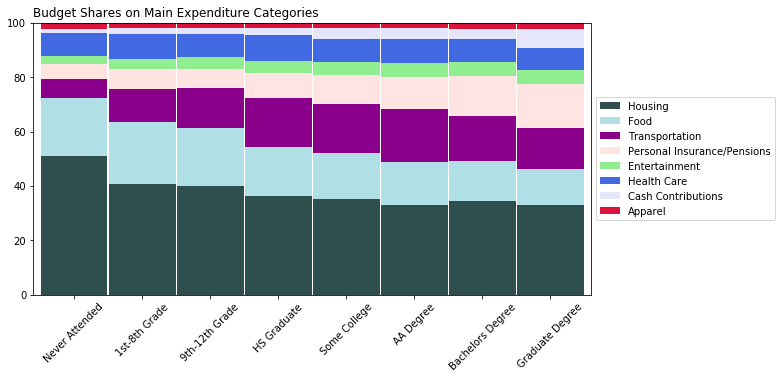

In [11]:
data = tab[exp_vars]
ind = range(len(data.index.tolist()))
x_labs = data.index.tolist()

colors = ('darkslategrey', 'powderblue', 'darkmagenta', 'mistyrose',
          'lightgreen', 'royalblue', 'lavender', 'crimson')

labels = {'FOODPQ': 'Food', 'HOUSPQ': 'Housing', 'APPARPQ': 'Apparel', 
          'TRANSPQ': 'Transportation', 'HEALTHPQ': 'Health Care',
          'ENTERTPQ': 'Entertainment', 'CASHCOPQ': 'Cash Contributions', 
          'PERINSPQ': 'Personal Insurance/Pensions' }

cum_sum = np.array([0,0,0,0,0,0,0,0])

plt.figure(figsize=(10,5))

i = 0
for var in exp_vars:
    next_color = colors[i]
    next_lab = labels[var]
    plt.bar(ind, data[var], bottom=cum_sum, width=0.98,
            color=next_color, label=next_lab)
    cum_sum = cum_sum + data[var].values
    i += 1

plt.xticks(ind, data.index, rotation=45)
plt.xlim(min(ind) - 0.6, max(ind) + 0.6)
plt.ylim(0,100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Budget Shares on Main Expenditure Categories', loc='left')
plt.show()

# Conclusion
<p>Thanks for letting me show you a little bit about how you can use Jupyter along with Python libraries like Pandas and Matplotlib to analyize BLS data. Feel free to contact me at <code>knappenerger.clayton@bls.gov</code> if you have any questions or if you want to be added to the Python Users Group (PUG). If you have any Python questions you can also email PUG at <code>PUG@bls.gov</code> or you can check out our SharePoint <url>http://osmr.cfsp.bls.gov/python-user-group/SitePages/Home.aspx,</url>.</p>
<img src="https://www.python.org/static/community_logos/python-logo-master-v3-TM.png">

# Appendix: Matplotlib 
<p>Above we made a graph that showed monthly unemployment rates. It was a pretty simple graph meant to show how easy it can be to make plots with matplotlib. Here though I wanted to take that graph from above and make some changes to demonstrate just how powerful a tool matplotlib can be. The point is primarily to demonstrate the different tools at your disposal including:</p>
1. Subplots that share an x-axis
2. Region shading
3. Horizontal Reference Line
4. "Smart" bounds axes

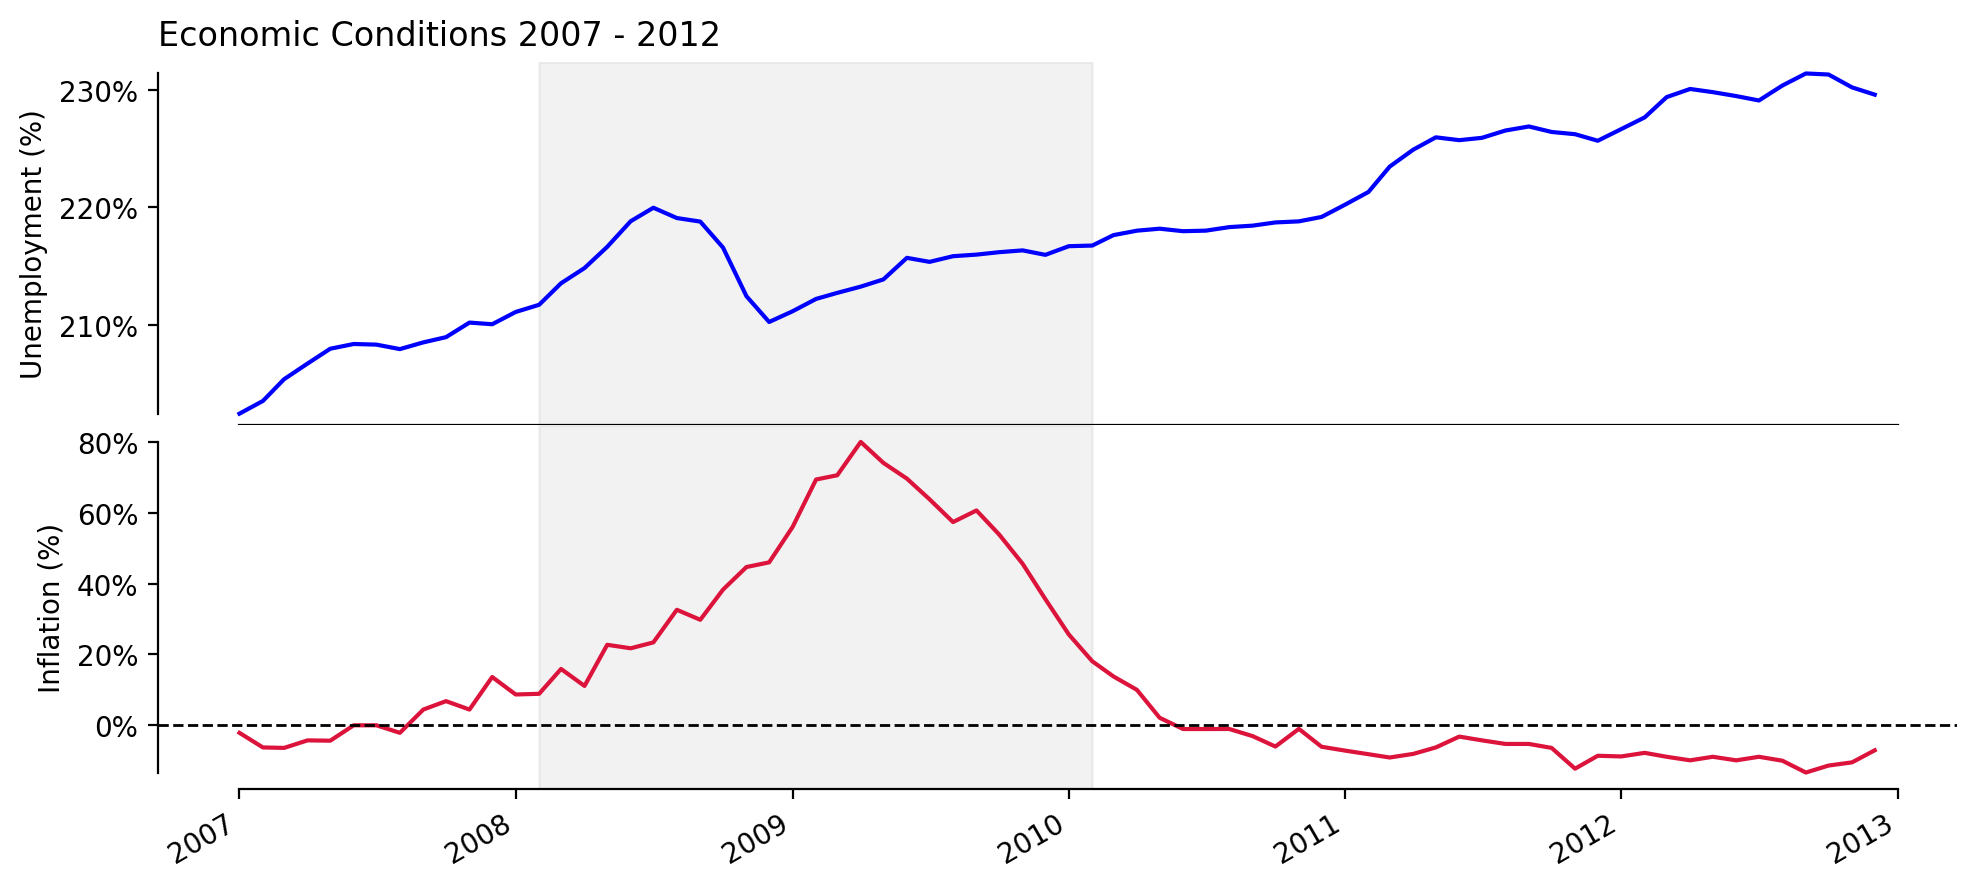

In [12]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3 = df3['2007':'2012']

fmt = '{x:,.0f}%'
tick = mtick.StrMethodFormatter(fmt)
bs_un = df3['2008-03-01':'2008-03-01']['unemp'].values
max_un = df3['unemp'].max()
max_date = df3[df3['unemp'] == max_un].index
min_inf = df3['monthly'].min()
min_date = df3[df3['monthly'] == min_inf].index

fig, axarr = plt.subplots(2, figsize=(10,5), sharex=True, dpi=200)
axarr[0].set_title('Economic Conditions 2007 - 2012', loc='left')
axarr[0].set_ylabel('Unemployment (%)')
axarr[0].plot(df3.index, df3['unemp'], color='blue')
axarr[0].yaxis.set_major_formatter(tick)
axarr[0].set_ylim(min(df3['unemp']) - 1, 
            max(df3['unemp']) + 1)
axarr[0].spines['left'].set_smart_bounds(True)
axarr[0].spines['bottom'].set_smart_bounds(True)
axarr[0].spines['top'].set_visible(False)
axarr[0].spines['right'].set_visible(False)
axarr[0].axvspan('2008-02', '2010-02', alpha=0.1, color='grey')


axarr[1].plot(df3.index, df3['monthly'], color='crimson')
axarr[1].axhline(linestyle='dashed', color='black', linewidth=1)
axarr[1].set_ylabel('Inflation (%)')
axarr[1].spines['top'].set_visible(False)
axarr[1].spines['right'].set_visible(False)
axarr[1].spines['left'].set_smart_bounds(True)
axarr[1].spines['bottom'].set_smart_bounds(True)
axarr[1].yaxis.set_major_formatter(tick)
axarr[1].axvspan('2008-02', '2010-02', alpha=0.1, color='grey')

fig.tight_layout()
fig.autofmt_xdate()
fig.subplots_adjust(hspace=0)